# Chargement des données d’images

Jusqu’à présent, nous avons travaillé avec des ensembles de données assez artificiels, peu représentatifs des projets réels.  
Dans la pratique, vous serez souvent amené à manipuler des **images de grande taille**, comme celles issues d’appareils photo ou de téléphones portables.  
Dans ce notebook, nous verrons comment **charger des images** et les utiliser pour **entraîner des réseaux de neurones**.

Nous utiliserons un [jeu de données de photos de chats et de chiens](https://www.kaggle.com/c/dogs-vs-cats) disponible sur **Kaggle**.  
Voici quelques exemples d’images :



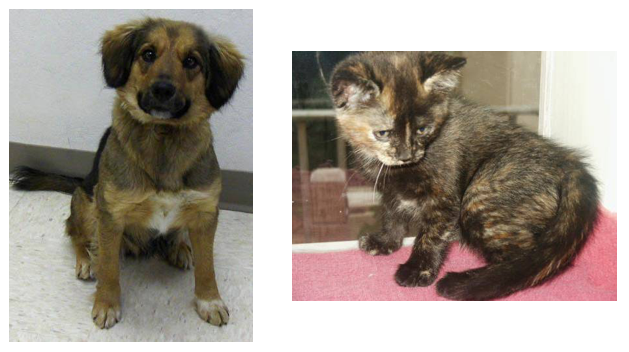

Nous emploierons ce jeu de données pour entraîner un réseau de neurones capable de **distinguer les chats des chiens**.  
Aujourd’hui, cela peut sembler banal, mais il y a encore quelques années, c’était un véritable **défi pour les systèmes de vision par ordinateur**.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import helper


La façon la plus simple de charger des images est d’utiliser `datasets.ImageFolder` de la bibliothèque **torchvision** ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)).  
En général, vous utiliserez `ImageFolder` comme ceci :

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
````

où `'path/to/data'` est le chemin d’accès au répertoire contenant les données, et `transform` est une **séquence d’opérations de prétraitement** définies à l’aide du module [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) de `torchvision`.

`ImageFolder` s’attend à une structure de répertoires comme celle-ci :

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

Chaque classe (ici `cat` et `dog`) possède son **propre dossier** contenant les images correspondantes.
Les images sont alors automatiquement **étiquetées** d’après le nom du dossier.
Ainsi, l’image `123.png` sera chargée avec l’étiquette `cat`.

Vous pouvez télécharger le jeu de données déjà structuré de cette manière [ici](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip).
Il est déjà séparé en **jeu d’entraînement** et **jeu de test**.

---

### 🔄 Transformations

Lors du chargement des données avec `ImageFolder`, il faut définir des **transformations (transforms)**.
Par exemple, les images ont des tailles différentes, mais le modèle nécessite qu’elles aient toutes la même taille pour l’entraînement.
On peut donc :

* les **redimensionner** avec `transforms.Resize()`, ou
* les **rogner** avec `transforms.CenterCrop()` ou `transforms.RandomResizedCrop()`.

Il faut également **convertir les images en tenseurs PyTorch** à l’aide de `transforms.ToTensor()`.

En général, ces étapes sont combinées en un pipeline à l’aide de `transforms.Compose()`, qui exécute une liste de transformations dans l’ordre.
Par exemple, pour redimensionner, recadrer, puis convertir en tenseur :

```python
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
```

Il existe de nombreuses autres transformations possibles — consultez la [documentation](http://pytorch.org/docs/master/torchvision/transforms.html) pour plus de détails.

---

### 📦 Data Loaders

Une fois le `ImageFolder` chargé, il faut le passer à un [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader).
Le **DataLoader** prend un dataset (par exemple celui renvoyé par `ImageFolder`) et retourne des **lots (batches)** d’images et leurs **étiquettes** correspondantes.
Vous pouvez régler plusieurs paramètres, comme :

* la **taille des lots (`batch_size`)**,
* et le **mélange des données (`shuffle`)** à chaque époque.

Exemple :

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

L’objet `dataloader` est un **générateur**.
Pour extraire des données, on peut soit boucler dessus, soit le convertir en itérateur et appeler `next()` :

```python
# Boucle pour récupérer un batch à chaque itération
for images, labels in dataloader:
    pass

# Obtenir un seul batch
images, labels = next(iter(dataloader))
```

---

> **Exercice :**
> Chargez les images depuis le dossier `Cat_Dog_data/train`,
> définissez quelques transformations,
> puis construisez le **DataLoader**.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# setting working Directory
import os
os.chdir('/content/drive/MyDrive/deep_learning/cat_dog_image_classification')

In [4]:
%ls

Cat_Dog_data/  helper.py


In [ ]:
# extract Cat_Dog_data.zip
#!unzip Cat_Dog_data.zip

In [5]:
data_dir = 'Cat_Dog_data/train'

# les transformations
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# le dataset avec ImageFolder
dataset = datasets.ImageFolder(data_dir, transform=transform)

#le DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

<Axes: >

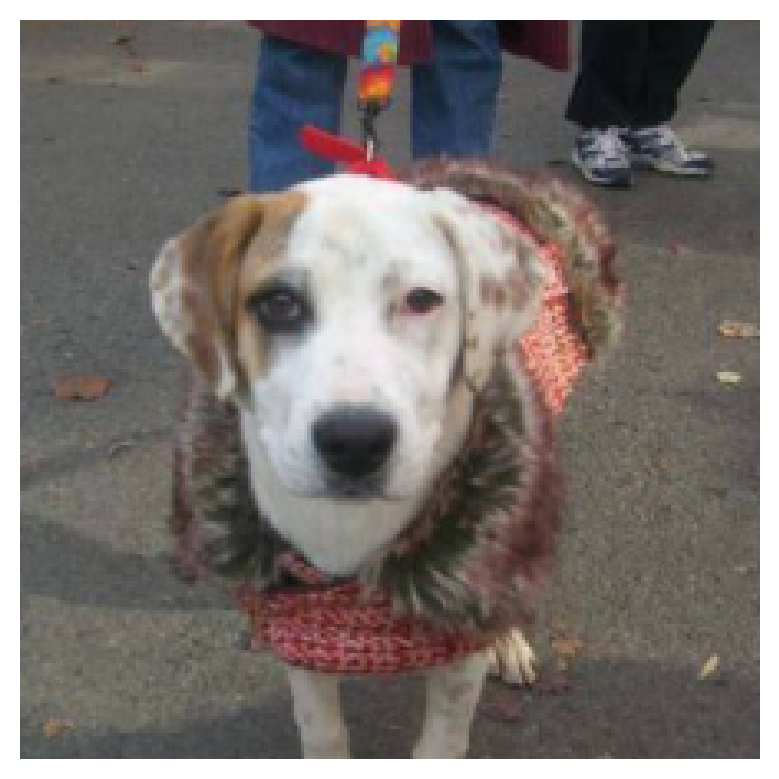

In [7]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
imshow(images[0], normalize=False)

Si vous avez correctement chargé les données, vous devriez obtenir un affichage similaire à celui-ci (votre image sera différente) :




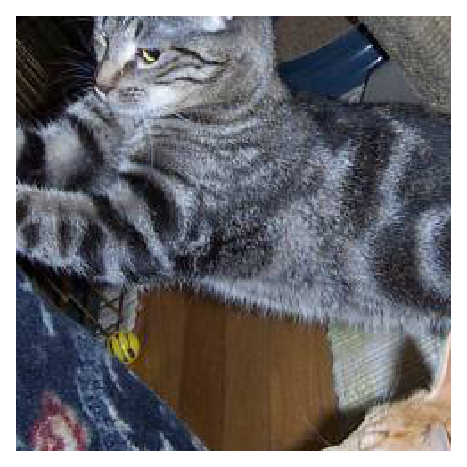


## Augmentation de Données

Une stratégie courante pour entraîner des réseaux de neurones consiste à introduire une **certaine forme d’aléatoire dans les données d’entrée**.  
Par exemple, on peut faire tourner, refléter, redimensionner et/ou rogner aléatoirement les images pendant l’entraînement.  
Cela aide le réseau à **mieux généraliser**, car il voit les mêmes images sous différentes formes : positions, tailles, orientations, etc.

Pour appliquer une rotation, un recadrage et un redimensionnement aléatoires, puis retourner les images horizontalement, on peut définir les transformations ainsi :

```python
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])
````

Il est également recommandé de **normaliser les images** à l’aide de `transforms.Normalize`.
Cette transformation prend en entrée :

* une liste de **moyennes** (`mean`)
* et une liste d’**écarts-types** (`std`)

Chaque canal de couleur est alors normalisé selon la formule :

```
input[channel] = (input[channel] - mean[channel]) / std[channel]
```

Soustraire la moyenne recentre les données autour de zéro,
et diviser par l’écart-type comprime les valeurs entre **-1 et 1**.
Cette normalisation aide à maintenir les **poids du réseau proches de zéro**,
rendant ainsi la **rétropropagation plus stable**.
Sans normalisation, le réseau risque souvent d’échouer à apprendre correctement.

Vous pouvez consulter la **liste complète des transformations disponibles** [ici](http://pytorch.org/docs/0.3.0/torchvision/transforms.html).

Lors des phases de **validation** ou de **test**, on utilise généralement des images **non altérées** (hormis la normalisation).
Ainsi, pour les données de validation ou de test, on se contente en général de **redimensionner** et **recadrer** les images.

---

> **Exercice :**
> Définissez ci-dessous les **transformations** pour les données d’entraînement et de test.
> Ne mettez pas encore la normalisation.

```



In [8]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data

data_dir = 'Cat_Dog_data'

# Pour l'entraînement
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],   # Moyenne pour R, G, B
                         [0.5, 0.5, 0.5])   # Écart-type pour R, G, B
])

# Pour le test
test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# On divise les donnée d'entrainement en deux dataset
train_size = int(0.8 * len(train_data))   # 80% pour l'entraînement
val_size = len(train_data) - train_size   # 20% pour la validation

train_subset, val_subset = random_split(train_data, [train_size, val_size])

# Création des DataLoaders
trainloader = DataLoader(train_subset, batch_size=32, shuffle=True)
valloader = DataLoader(val_subset, batch_size=32, shuffle=False)
testloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [9]:
# change this to the trainloader or testloader
data_iter = iter(trainloader)

In [10]:
images, labels = next(data_iter)
labels

tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 0])

In [11]:
train_data.class_to_idx

{'cat': 0, 'dog': 1}

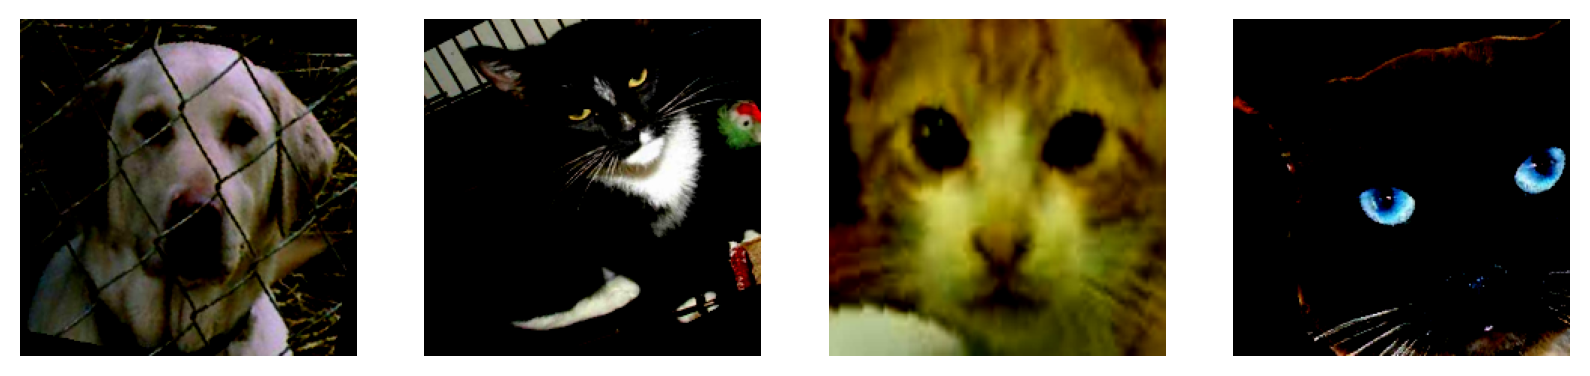

In [12]:


images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    img = np.clip(images[ii], 0, 1) #forcer un clipping manuel pour eviter le warning rgb
    imshow(img, ax=ax, normalize=False)

Vos images transformées devraient ressembler à quelque chose comme ceci.




<center>Training examples:</center>


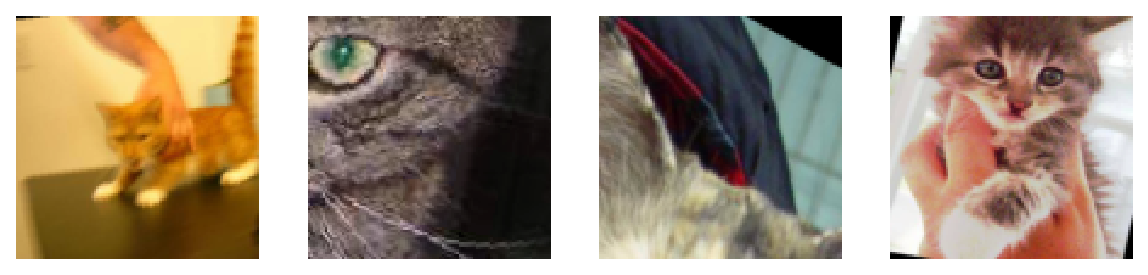

<center>Testing examples:</center>

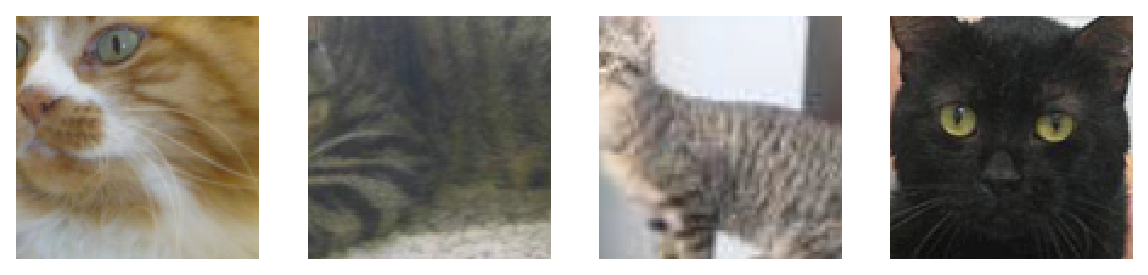


À ce stade, vous devriez être en mesure de charger les données pour l’entraînement et le test.  
Vous pouvez maintenant essayer de construire un réseau capable de **classer les chats et les chiens**.



In [ ]:
#  TODO: Attempt to build a network with CNN to classify cats vs dogs from this dataset
# --- créer un model from scratc

# TP – CNN “from scratch” vs Transfert Learning (Cats vs Dogs)

## Objectif

Comparer **un modèle CNN entraîné from scratch** et **un modèle en transfert d’apprentissage** sur le même jeu de données (cats vs dogs). Montrer l’impact du transfert learning sur la convergence, la performance et la robustesse.

## Ce qui est **obligatoire**

1. **Deux expériences distinctes**

   * Expérience A : CNN **from scratch** (architecture simple minimum 3 bloc avec conv).
   * Expérience B : **Transfert learning** (ex. ResNet, MobileNet, EfficientNet…), couches finales adaptées.
2. **Bonnes pratiques de régularisation**

   * Utiliser **Dropout** ET **Batch Normalization** (justifier où et pourquoi).
3. **Suivi des métriques**

   * **Training loss**, **Accuracy**, **Précision**, **Recall** à chaque époque (et idéalement sur train/val si vous faites une validation).
   * Tracer des **courbes** et **comparer** les deux approches.
4. **Optimisation**

   * Tester au moins **2 optimiseurs** (ex. SGD et Adam).
   * Chercher un **bon learning rate** (essais ou scheduler).
5. **GPU**

   * Entraîner **sur GPU** si disponible (vérification et mention dans README).
6. **Persistance du modèle**

   * **Sauvegarder** le meilleur modèle (.pt/.pth) localement (ne **pas** pousser dans GitHub).
   * **Recharger** le modèle pour faire le **test final** et rapporter les métriques.
7. **Reproductibilité**

   * Fixer un **seed**

## Ce qui est **souhaité (bonus)**

* **Split train/validation** (clair et justifié).
* **Data augmentation** raisonnable.
* **Scheduler** (ex. StepLR, CosineAnnealingLR).
* **Matrice de confusion** et quelques **erreurs typiques** commentées.
* Journalisation (TensorBoard/W&B) — sans pousser les fichiers lourds.

## Données

* Utilisez le même corpus **Cats vs Dogs** que vu en cours (ou équivalent).
* Ne **poussez pas** les données sur GitHub. Indiquez seulement **comment** les télécharger/placer.

## Structure du dépôt GitHub (exemple)

```
cnn-catsdogs-<NomPrenom>/
├─ notebook.ipynb
├─ .gitignore
├─ requirements.txt (ou environment.yml)
├─ README.md
└─ LICENSE (optionnel)
```

### `.gitignore` (minimum)

```
data/
*.pt
*.pth
runs/
checkpoints/
```

## Contenu attendu du **README.md**

* **Titre & objectif** du projet.
* **Environnement** ( `pip install -r requirements.txt` ou `conda env create -f environment.yml`).
* **Organisation des données** (où télécharger, où placer les dossiers).
* **Commandes pour entraîner** :

  * From scratch : arguments clés (batch size, lr, epochs, optimiser, dropout, BN, scheduler…).
  * Transfert learning : même chose + quelle base (gel des couches ou fine-tuning).
* **Commandes pour évaluer / recharger le modèle** (chemin du checkpoint local).
* **Résultats** : tableaux + courbes (loss/accuracy/précision/recall) pour les deux expériences, **comparaison et analyse** (2–3 paragraphes).
* **Limites & pistes d’amélioration** (brèves).

## Évaluation (grille indicative)

* Rigueur expérimentale & métriques (30 %)
* Qualité des modèles & optimisation (25 %)
* Clarté du code & structure du dépôt (20 %)
* README (reproductibilité, analyse, figures) (20 %)
* Bonus (val split, augmentation, scheduler, confusion matrix) (5 %)

## Remise

* **Poussez votre code sur GitHub** (sans données ni modèles).
* Envoyez **le lien du dépôt** à **[diallomous@gmail.com](mailto:diallomous@gmail.com)**
* **Date limite : mercredi  22 octobre 2025 à 18:00 (Africa/Dakar).**

> Rappel : ne chargez pas les fichiers lourds (datasets, `.pt/.pth`). Assurez-vous que votre dépôt permet de **reproduire** les expériences via les instructions du README.


#**Deux expériences distinctes**

On importe ici les outils dont on aura besoin

In [13]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import  models
from torch.utils.data import random_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
from tqdm import tqdm
import wandb

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device utilisé : {device}")

✅ Device utilisé : cuda


**- Expérience A : CNN from scratch (architecture simple minimum 3 bloc avec conv)**

Définissons notre modele CNN

Ce modèle définit un réseau de neurones convolutif (CNN)
    pour la classification d’images (ici : chats vs chiens).
    
    Architecture générale :
    - 3 couches convolutionnelles + normalisation de lot + ReLU + MaxPooling
    - 1 couche entièrement connectée cachée
    - 1 couche de sortie (2 classes)

In [15]:

class Modele_CNN(nn.Module):
    def __init__(self):

        super().__init__()   # On appelle le constructeur de la classe parente nn.Module

        # 1ere couche convolutionnelle
        # nn.Conv2d(in_channels, out_channels, kernel_size, padding) in_channels = 3 : car image RGB,- out_channels = 32 : nombre de filtres à apprendre
        # - kernel_size = 3 : taille du filtre (3x3) - padding = 1 : pour garder la taille spatiale
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)

        self.bn1 = nn.BatchNorm2d(32) # Normalisation de lot pour stabiliser l'entraînement

        # 2eme couche convolutionnelle
        # - in_channels = 32 : en entrée, on reçoit les 32 cartes précédentes  - out_channels = 64 : on apprend 64 filtres - kernel_size = 3 : même taille de filtre
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # 3eme couche convolutionnelle
        # - in_channels = 64 : on reçoit les 64 cartes de la couche précédente - out_channels = 128 : on apprend encore plus de filtres
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Max pooling pour réduire la dimension spatiale (2x2)(- kernel_size = 2 : réduit chaque dimension par 2 - stride = 2 : déplacement du filtre de 2 pixels)
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout pour réduire le surapprentissage  - p = 0.3 : 30% des neurones désactivés pendant l'entraînement
        self.dropout = nn.Dropout(0.3)

        # Première couche entièrement connectée (dense)
        # - input = 128 * 28 * 28 : taille après la 3e convolution + pooling - output = 512 : taille du vecteur caché
        self.fc1 = nn.Linear(128 * 28 * 28, 512)

        # Couche de sortie
        # - input = 512 : sortie de la couche précédente - output = 2 : deux classes (chat / chien)
        self.fc2 = nn.Linear(512, 2)

    # Décrit le passage avant (forward pass) des données dans le réseau.
    def forward(self, x):


        # Bloc 1 : convolution + batchnorm + ReLU + pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Bloc 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Bloc 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Mise à plat (flatten) des tenseurs 4D en vecteurs 2D
        # -1 = batch size automatique
        x = x.view(-1, 128 * 28 * 28)

        # Couche entièrement connectée + dropout
        x = self.dropout(F.relu(self.fc1(x)))

        # Couche de sortie (logits non normalisés)
        x = self.fc2(x)

        return x


Fonction générique pour l'entrainement

In [16]:


def train_model(model, criterion, optimizer, trainloader, valloader, epochs=5, project_name="CNN_Comparison", run_name="experiment"):

    wandb.init(project=project_name, name=run_name, config={
        "epochs": epochs,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": optimizer.param_groups[0]['lr'],
        "architecture": model.__class__.__name__,
        "batch_size": trainloader.batch_size
    })

    model.to(device)
    wandb.watch(model, log="gradients", log_freq=100)

    history = {'train_loss': [],'train_accuracy':[], 'val_loss': [], 'val_acc': []} # enregistrer les performances à chaque passage

    for epoch in range(epochs):

        # Phase d'entraînement
        model.train()
        running_loss, correct_train, total_train = 0, 0, 0
        for inputs, labels in tqdm(trainloader, desc=f"Époque {epoch+1}/{epochs}"): # la boucle
            inputs, labels = inputs.to(device), labels.to(device) #Déplace les données et les étiquettes sur le GPU (ou CPU) pour calcul

            optimizer.zero_grad() # mettre à zéro les gradients accumulés de la précédente itération
            outputs = model(inputs) # Passer les données dans le modèle → prédictions
            loss = criterion(outputs, labels) # Calculer la perte entre les prédictions et les vraies étiquettes
            loss.backward() # Calculer les gradients de la perte par rapport aux poids du modèle
            optimizer.step() # Mettre à jour les poids du modèle selon les gradients calculés.
            running_loss += loss.item() # Ajoute la valeur de la perte de ce lot pour suivre la moyenne
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = correct_train / total_train

        # Phase de Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0  #Initialiser les compteurs: perte totale, nombre de prédictions correctes, nombre total d’images.
        with torch.no_grad(): # Désactiver la calcul des gradients
            for inputs, labels in valloader: # Boucle sur les données de validation
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)

        val_acc = correct / total # Calcule la précision globale sur le jeu de validation
        #Enregistrer les statistiques de cette époque dans history
        history['train_loss'].append(running_loss / len(trainloader))
        history['val_loss'].append(val_loss / len(valloader))
        history['train_accuracy'].append(train_acc),
        history['val_acc'].append(val_acc)

        # --- Suivi wandb ---
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": running_loss / len(trainloader),
            "train_accuracy": train_acc,
            "val_loss": val_loss / len(valloader),
            "val_accuracy": val_acc
        })

        #Affiche un résumé clair des performances à la fin de chaque époque.
        print(f"Epoch {epoch+1}: Train Loss={running_loss/len(trainloader):.3f}, Val Loss={val_loss/len(valloader):.3f}, Val Acc={val_acc:.3f}")

    wandb.finish()
    return model, history # le modèle entraîné et l’historique complet des pertes et précisions pour analyse et visualisation

On peut maintenant instancier notre "Modele_CNN", définir sa sa fonction de perte et son optimiseur.

On entraine ce modele pendant 5 époques et le sauvegarder.

In [17]:

model_scratch = Modele_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=0.001)

model_scratch, hist_scratch = train_model(model_scratch, criterion, optimizer, trainloader, valloader, epochs=5, project_name="Cats_vs_Dogs", run_name="CNN_From_Scratch")


torch.save(model_scratch.state_dict(), 'cnn_from_scratch.pth') # Sauvegarde les poids du modèle entraîné dans le fichier cnn_from_scratch.pt


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ingndiaye (ingndiaye-afma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Époque 1/5: 100%|██████████| 563/563 [2:04:29<00:00, 13.27s/it]


Epoch 1: Train Loss=1.843, Val Loss=0.634, Val Acc=0.635


Époque 2/5: 100%|██████████| 563/563 [02:53<00:00,  3.24it/s]


Epoch 2: Train Loss=0.642, Val Loss=0.636, Val Acc=0.631


Époque 3/5: 100%|██████████| 563/563 [02:52<00:00,  3.27it/s]


Epoch 3: Train Loss=0.639, Val Loss=0.617, Val Acc=0.659


Époque 4/5: 100%|██████████| 563/563 [02:52<00:00,  3.27it/s]


Epoch 4: Train Loss=0.643, Val Loss=0.599, Val Acc=0.662


Époque 5/5: 100%|██████████| 563/563 [02:52<00:00,  3.27it/s]


Epoch 5: Train Loss=0.650, Val Loss=0.622, Val Acc=0.655


epoch,▁▃▅▆█
train_accuracy,▁▆█▃▁
train_loss,█▁▁▁▁
val_accuracy,▂▁▇█▆
val_loss,██▄▁▅
epoch,5
train_accuracy,0.60433
train_loss,0.64969
val_accuracy,0.65497
val_loss,0.62182


**- Expérience B — Transfert Learning (ResNet18)**

Ici on utilise le modèle pré-entraîné ***ResNet18***

C’est une architecture de réseau de neurones profonde et performante, déjà entraînée pour reconnaître des objets généraux.


In [18]:

model_transfer = models.resnet18(weights='IMAGENET1K_V1') # Charger le modèle ResNet18
for param in model_transfer.parameters():
    param.requires_grad = False  # ne pas mettre à jour leurs paramètres pendant l’entraînement

num_ftrs = model_transfer.fc.in_features #nombre d’entrées de la couche finale (fc)

#Ici réduit la dimension vers 256 neurones, applique une activation non linéaire, évite le surapprentissage et on a sortie avec 2 classes
model_transfer.fc = nn.Sequential(nn.Linear(num_ftrs, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, 2)) # Remplacer la couche finale (fc) du modèle par une nouvelle

criterion = nn.CrossEntropyLoss() # Fonction de perte
optimizer = optim.Adam(model_transfer.fc.parameters(), lr=0.001) # on utilise l'optimiseur Adam

#Entraînement du modèle pendant 5 époques en utilisant la fonction train_model : seules les couches finales apprennent, l’historique des pertes et précisions est enregistré dans hist_transfer
model_transfer, hist_transfer = train_model(model_transfer, criterion, optimizer, trainloader, valloader, epochs=5, project_name="Cats_vs_Dogs", run_name="ResNet18_TransferLearning")
torch.save(model_transfer.state_dict(), 'cnn_transfer.pth')  # Sauvegarde les poids du modèle entraîné dans le fichier cnn_from_scratch.pt


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


Époque 1/5: 100%|██████████| 563/563 [02:30<00:00,  3.74it/s]


Epoch 1: Train Loss=0.223, Val Loss=0.191, Val Acc=0.916


Époque 2/5: 100%|██████████| 563/563 [02:26<00:00,  3.86it/s]


Epoch 2: Train Loss=0.194, Val Loss=0.154, Val Acc=0.937


Époque 3/5: 100%|██████████| 563/563 [02:27<00:00,  3.81it/s]


Epoch 3: Train Loss=0.186, Val Loss=0.141, Val Acc=0.939


Époque 4/5: 100%|██████████| 563/563 [02:29<00:00,  3.78it/s]


Epoch 4: Train Loss=0.183, Val Loss=0.150, Val Acc=0.939


Époque 5/5: 100%|██████████| 563/563 [02:28<00:00,  3.78it/s]


Epoch 5: Train Loss=0.183, Val Loss=0.134, Val Acc=0.941


epoch,▁▃▅▆█
train_accuracy,▁▆█▇█
train_loss,█▃▁▁▁
val_accuracy,▁▇▇██
val_loss,█▃▂▃▁
epoch,5
train_accuracy,0.91911
train_loss,0.1832
val_accuracy,0.9409
val_loss,0.13402


**Comparaison graphique des performances**

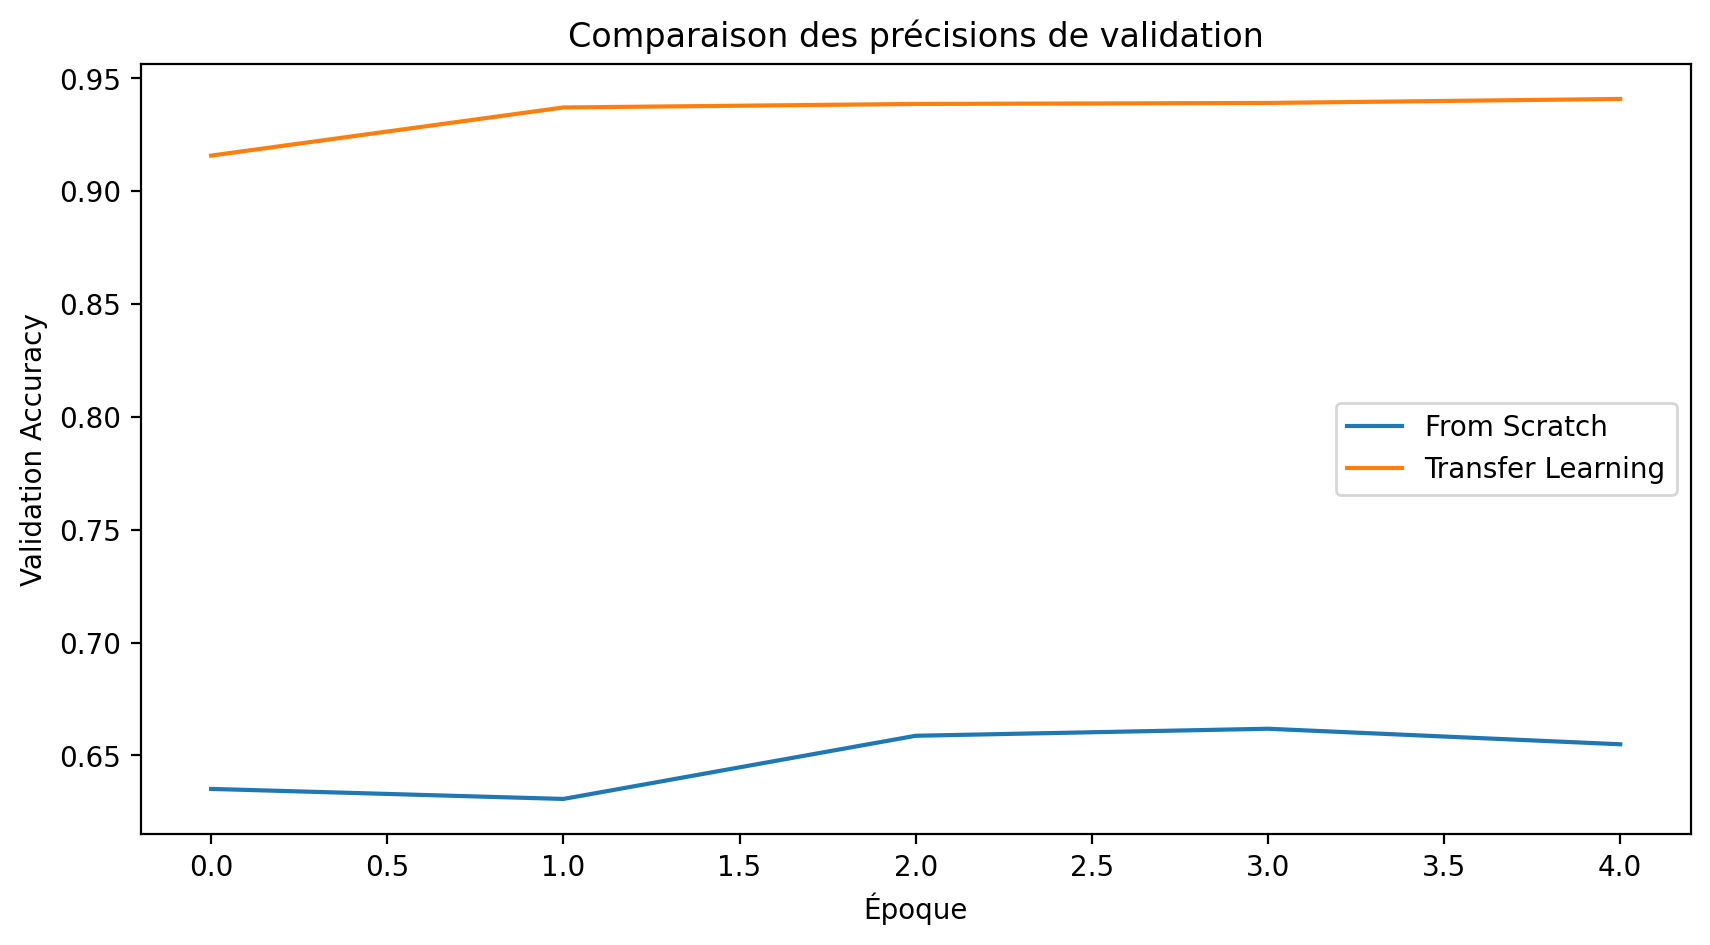

In [19]:
plt.figure(figsize=(10,5))
plt.plot(hist_scratch['val_acc'], label='From Scratch')
plt.plot(hist_transfer['val_acc'], label='Transfer Learning')
plt.xlabel('Époque')
plt.ylabel('Validation Accuracy')
plt.title('Comparaison des précisions de validation')
plt.legend()
plt.show()

**Évaluation finale sur le test set**

In [22]:
def evaluate_model(model, loader):
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    # train_data est déjà un ImageFolder
    print(classification_report(labels_all, preds_all, target_names=train_data.classes))
    cm = confusion_matrix(labels_all, preds_all)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_data.classes, yticklabels=train_data.classes)
    plt.title("Matrice de confusion")
    plt.show()


=== Test CNN From Scratch ===
              precision    recall  f1-score   support

         cat       0.62      0.82      0.70      2290
         dog       0.72      0.48      0.57      2211

    accuracy                           0.65      4501
   macro avg       0.67      0.65      0.64      4501
weighted avg       0.67      0.65      0.64      4501



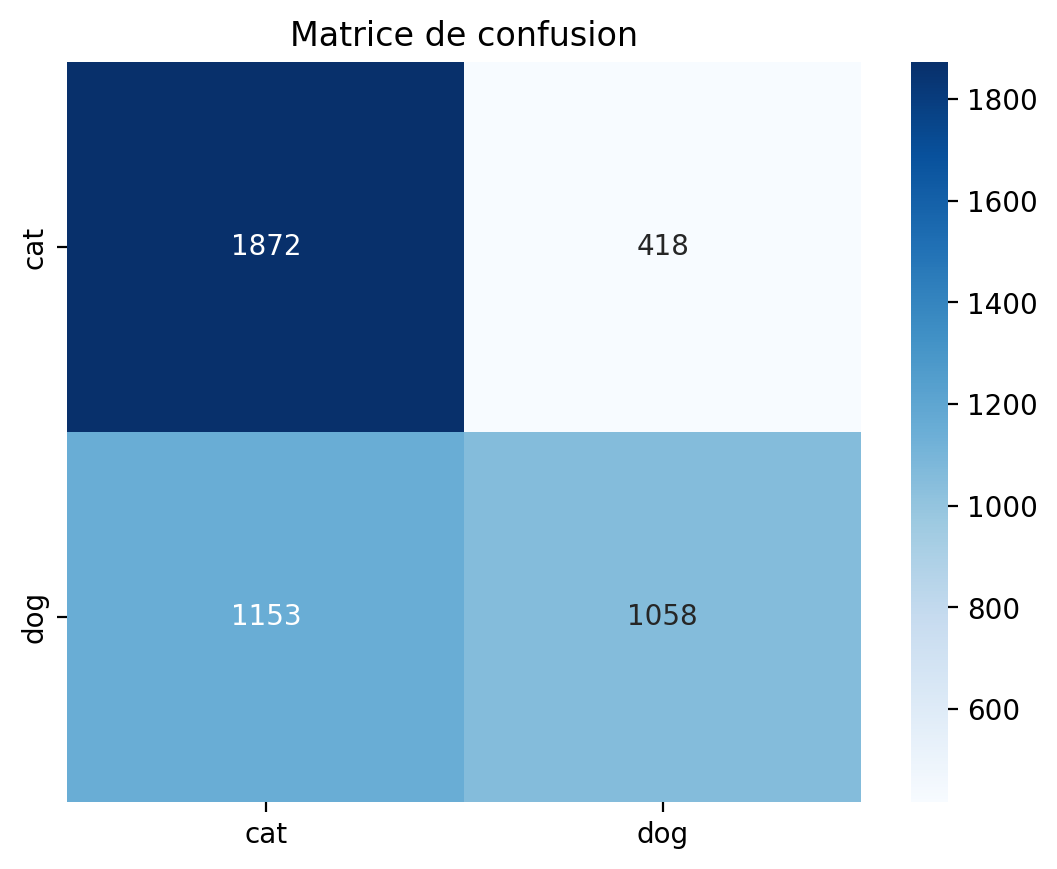


=== Test Transfer Learning ===
              precision    recall  f1-score   support

         cat       0.95      0.93      0.94      2290
         dog       0.93      0.95      0.94      2211

    accuracy                           0.94      4501
   macro avg       0.94      0.94      0.94      4501
weighted avg       0.94      0.94      0.94      4501



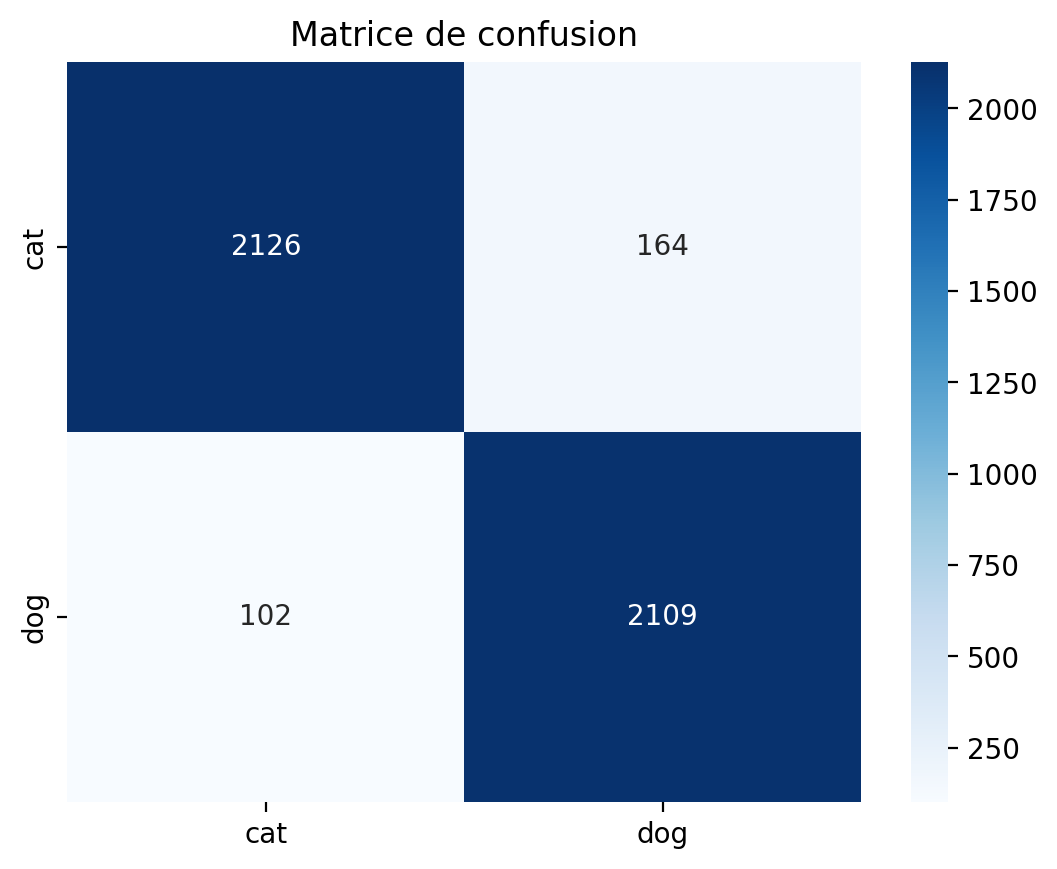

In [23]:

print("\n=== Test CNN From Scratch ===")
evaluate_model(model_scratch, valloader)

print("\n=== Test Transfer Learning ===")
evaluate_model(model_transfer, valloader)

#ANALYSE DES RESULTATS
Avec ces resultat on constate que que le modèle en "**Transfert Learning**" surpasse largement le modèle "**From scratch**".

On peut donc expliquer cela par les faits suivant :

  - L’apprentissage "**From scratch**" n’a pas eu assez de données ou d’époques pour bien généraliser.
  - Le modèle "**Transfert Learning**" ResNet18 possède déjà des connaissances visuelles générales issues d’ImageNet. Il a donc rapidement appris à distinguer les caractéristiques spécifiques entre chats et chiens.
  - Le fine-tuning ou remplacement de la dernière couche permet une adaptation rapide et efficace à ton dataset.

Le "**Transfert Learning**" est clairement supérieur, surtout sur des jeux de données de taille moyenne.

Le modèle "**From scratch**" pourrait s’améliorer avec :

  - plus d’images
  - un nombre d’époques plus élevé
  - un meilleur réglage du taux d’apprentissage ou une architecture plus profonde.  

#**Test des modele sauvegardés**


Rechageons nos modéles sauvegarder et testons les à nouveau

In [25]:
# Charger les modèles enregistrés
cnn_scratch = Modele_CNN()
cnn_scratch.load_state_dict(torch.load("cnn_from_scratch.pth", map_location=device))
cnn_scratch.to(device)
cnn_scratch.eval()

cnn_transfer = models.resnet18(weights=None)
num_ftrs = cnn_transfer.fc.in_features
cnn_transfer.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)
cnn_transfer.load_state_dict(torch.load("cnn_transfer.pth", map_location=device))
cnn_transfer.to(device)
cnn_transfer.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


=== Test CNN From Scratch ===
              precision    recall  f1-score   support

         cat       0.51      0.99      0.68      1250
         dog       0.90      0.06      0.12      1250

    accuracy                           0.53      2500
   macro avg       0.70      0.53      0.40      2500
weighted avg       0.70      0.53      0.40      2500



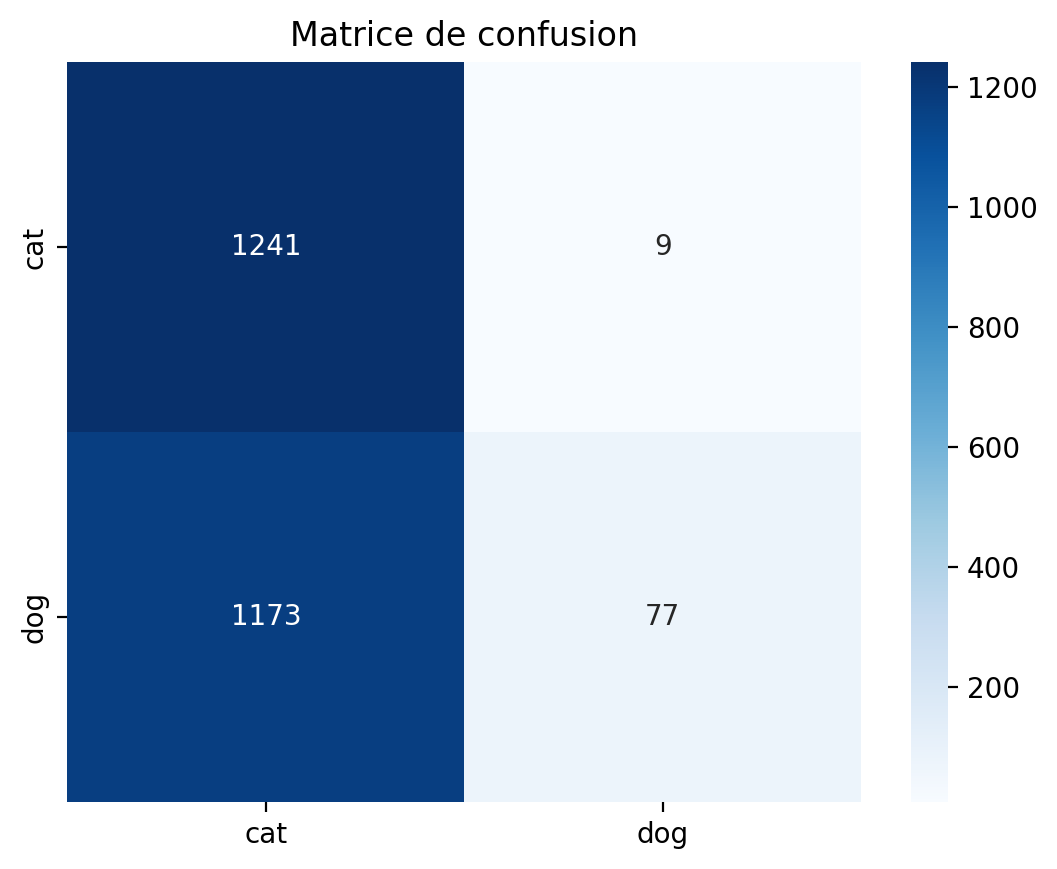


=== Test Transfer Learning ===
              precision    recall  f1-score   support

         cat       0.96      0.97      0.97      1250
         dog       0.97      0.96      0.97      1250

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



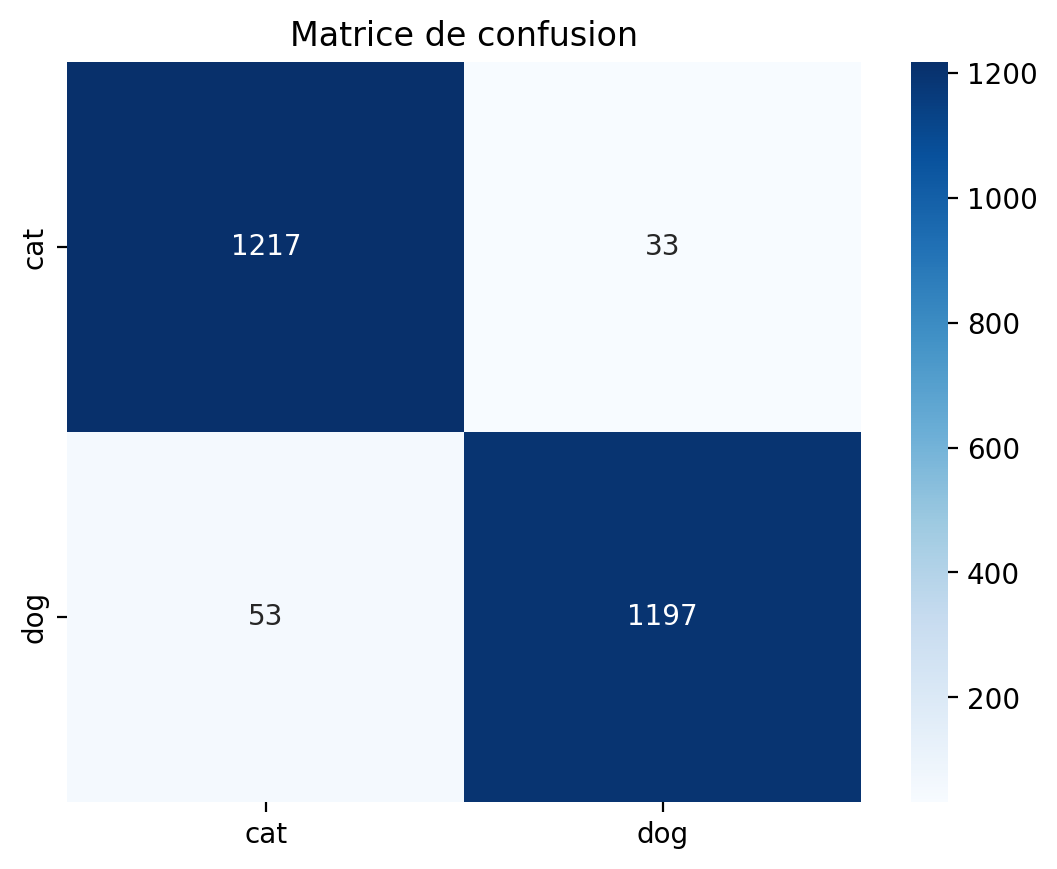

In [26]:
print("\n=== Test CNN From Scratch ===")
evaluate_model(cnn_scratch, testloader)

print("\n=== Test Transfer Learning ===")
evaluate_model(cnn_transfer, testloader)